# Part I - Ford GoBike System Data Exploration

##### by Vu Le


## Introduction

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area on February 2019. Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area. It is operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District.

## Investigation Overview

The analysis hereinafter would focus in the behaviours of the users (i.e.trip duration, gender of member, is the member the customer or subcriber, etc.) under the aspect of time.

## Dataset Overview

The dataset contains 183.412 rows with 13 columns recording the information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area for February 2019. Among the columns in the dataset, there are 1 category type, 2 datetime type, 1 float type, 1 integer and 4 object type columns.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

#### Data Quality issues and Enrichment

##### Data Quality

1. Some columns are not in the right data type (i.e. start_time, end_time, bike_id, user_type, member_birth_year, etc.)

2. Some columns would not be used for the analysis and should be dropped off

##### Enrichment

1. Because the dataset has complete datetime column (i.e. start_time, end_time) in the form where we could leverage to extract more information as follows:
    - time of a day
    - day of a week
    - day of a month

2. Enrich the age of member column to replace the member_year due to the missing data issue

3. Calculate the trip duration in minutes instead of seconds

In [2]:
df = pd.read_csv('201902-fordgobike-tripdata-cleaned.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,time_of_day,day_of_week,day_of_month,member_age,duration_min
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),13.0,Commercial St at Montgomery St,4902,Customer,1984.0,Male,17,Thursday,28,38,869.750000
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,81.0,Berry St at 4th St,2535,Customer,NaN,NaN,18,Thursday,28,0,708.683333
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,3.0,Powell St BART Station (Market St at 4th St),5905,Customer,1972.0,Male,12,Thursday,28,50,1030.900000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,70.0,Central Ave at Fell St,6638,Subscriber,1989.0,Other,17,Thursday,28,33,608.166667
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,222.0,10th Ave at E 15th St,4898,Subscriber,1974.0,Male,23,Thursday,28,48,26.416667


In [3]:
# because the new dataset imported, all the column data type are changed
# change the data type of some columns
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_station_id'] = df['start_station_id'].astype('str').apply(lambda x: x.replace('.0',''))
df['end_station_id'] = df['end_station_id'].astype('str').apply(lambda x: x.replace('.0',''))
df['bike_id'] = df['bike_id'].astype('str')
df['user_type'] = df['user_type'].astype('category')

In [4]:
# Make a copy of the dataset
master_df = df.copy()

In [5]:
#create a function to make a countplot
def makeCountplot(data, xVar, hueVar = None, palette = None, color = None, order = None, figsize = [20,7], labelsize = 15, title = ''):
    
    #turn off plt.figure() when there are subplots
    if figsize:
        plt.figure(figsize = figsize)
    
    #make the countplot
    sns.countplot(data = data,
                  x= xVar, 
                  hue = hueVar, 
                  color = color, 
                  order = order, 
                  palette = palette)
    
    #Clean up value of variable
    xVar = xVar.replace('_', ' ')
    
    if hueVar:
        hueVar = hueVar.replace('_',' ')
        
    #Add information of a plot
    plt.xlabel(xVar.title(), size = labelsize)
    plt.ylabel('Frequency',size = labelsize)


    plt.title(f"""Distribution of {xVar}{' by ' if hueVar else ''}{hueVar if hueVar else ''}{title}""".title(), 
                  fontsize = 20, weight = 'bold')
    sns.despine()

In [6]:
#create a function to make a lineplot
def makeLineplot(data, figsize = [25,7], color = None,user = None, xticks = [1000,10000,2000], yticks = [1,32,1], ylim = None):
    #turn off the figsize when there are subplots
    if figsize:
        plt.figure(figsize = figsize)
        
    #create a lineplot
    if user:
        sns.lineplot(data = data[user], dashes = False, color = color)
    else:
        sns.lineplot(data = data, dashes = False, color = color)
        
    #xticks
    if xticks:
        x1, x2, x3 = xticks
        plt.xticks(np.arange(x1,x2,x3))
    
    #yticks
    if yticks:
        y1, y2, y3 = yticks
        plt.yticks(np.arange(y1,y2,y3))
    
    #set limit to y axis
    if ylim:
        ylim1, ylim2 = ylim
        plt.ylim(ylim1, ylim2)
    
    #add information of the plot
    plt.xlabel('Day of month', size = 20)
    plt.ylabel('Frequency', size = 20)
    
    #add title of the plot
    plt.title(f'''Number of trip by day of month{': ' if user else ''}{user if user else ''}''', size = 30, weight = 'bold')

### The most 10 common start_station and end_station

There are 9 over 10 most common start station are also the most common end stations

In [7]:
#The most 10 common start_station and end_station
top_start = master_df.start_station_name.value_counts().sort_values(ascending = False).head(10)
start_station = master_df[master_df['start_station_name'].isin(top_start.index)].start_station_name


top_end = master_df.end_station_name.value_counts().sort_values(ascending = False).head(10)
end_station = master_df[master_df['end_station_name'].isin(top_end.index)].end_station_name

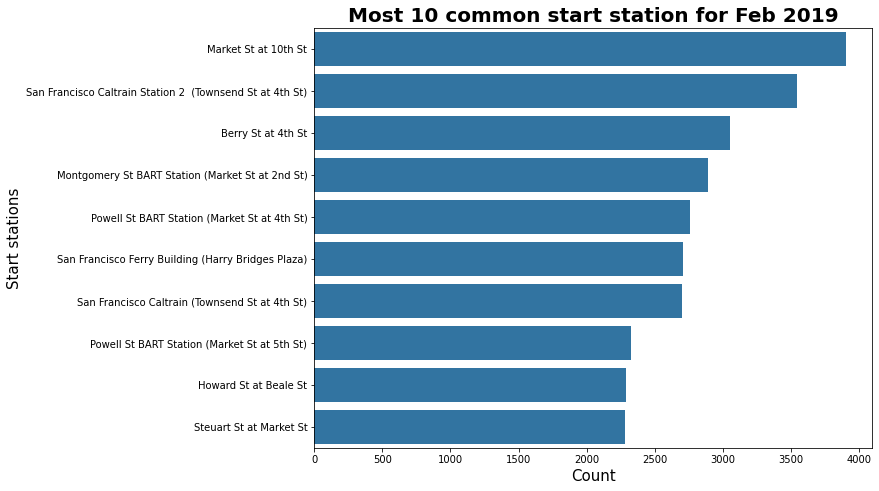

In [8]:
#Visualize the top common start_station and end_station
base_color = sns.color_palette()[0]
plt.figure(figsize = [10,17])
#start station
plt.subplot(2,1,1)
sns.countplot( y = start_station, color = base_color, order = top_start.index)

plt.xlabel('Count', size = 15)
plt.ylabel('Start stations', size = 15)
plt.title('Most 10 common start station for Feb 2019', weight = 'bold', size = 20)

plt.show();

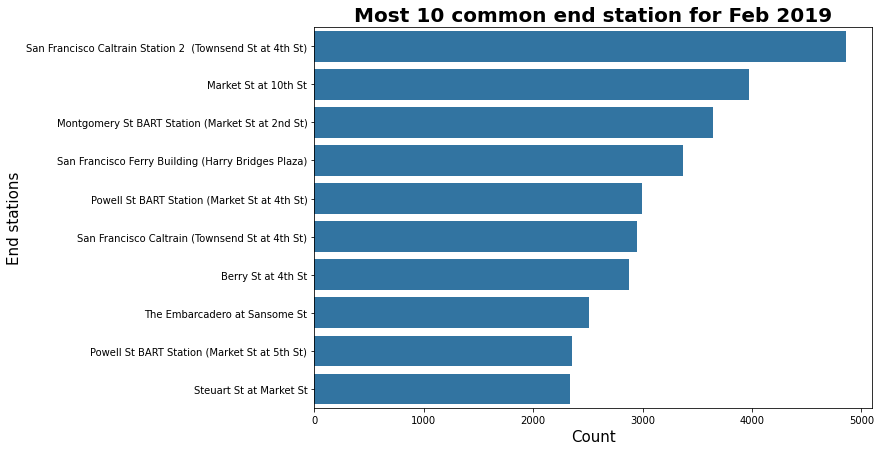

In [9]:
#end station
plt.figure(figsize = [10,7])
sns.countplot( y = end_station, color = base_color, order = top_end.index)

plt.xlabel('Count', size = 15)
plt.ylabel('End stations', size = 15)
plt.title('Most 10 common end station for Feb 2019', weight = 'bold', size = 20)

plt.show();

### Distribution of trip duration in Minutes

- The trip lengths vary in a relatively substantial range from 1 minute to over 14,000 minutes (24 hours equivalent)
- In the log scaled plot, it shows that it is skewed to the right with most of the trips take 3 to 50 minutes, where 5 minutes is the most common duration of a trip, and only a minority take more than 100 minutes for a ride.

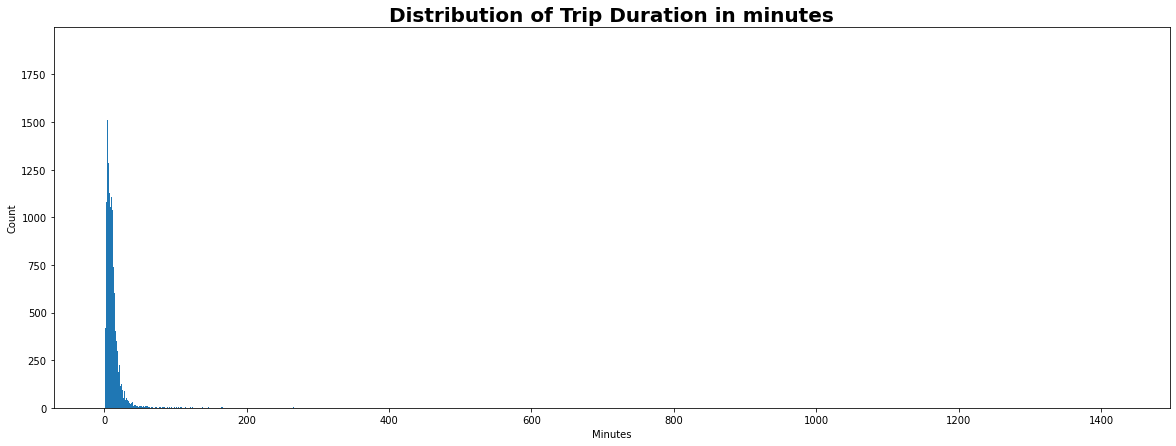

In [10]:
# illustrate the distribution of the trip duration
plt.figure(figsize = [20,7])
bins = np.arange(0, master_df['duration_min'].max() + 1, 0.1)
plt.hist(data = master_df, x = 'duration_min', bins = bins)

plt.xlabel('Minutes')
plt.ylabel('Count')
plt.title('Distribution of Trip Duration in minutes', size = 20, weight = 'bold')

plt.show();

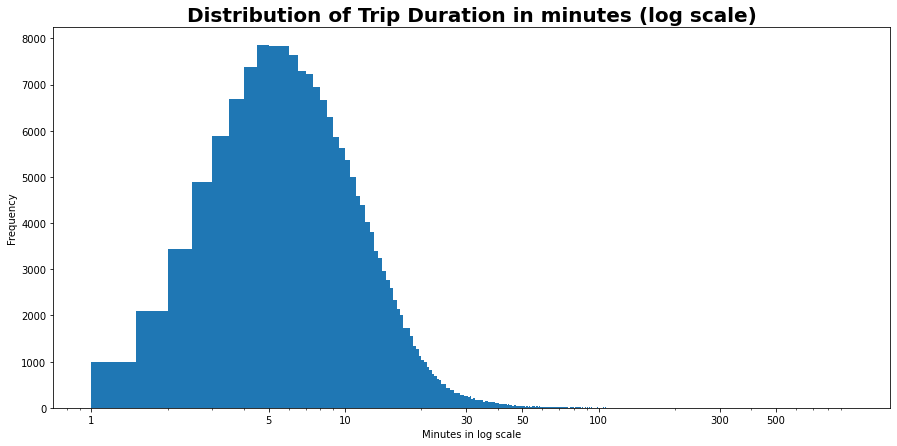

In [11]:
#Histogram chart of trip duration in minutes in log scale
plt.figure(figsize = [15,7])
bins = np.arange(1, 1000, 0.5)
plt.hist(data = master_df, 
         x = 'duration_min', 
         bins = bins)

# Generate the x-ticks you want to apply
ticks = [1, 5, 10, 30, 50, 100, 300, 500]
# Convert ticks into string values, to be displayed the x-axis
labels = ['{}'.format(tick) for tick in ticks]

plt.xlabel('Minutes in log scale')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration in minutes (log scale)', size = 20, weight = 'bold')

#apply the x log scale
plt.xscale('log')


#apply x tick
plt.xticks(ticks, labels)
plt.show();

### Proportion of member's gender

- The majority of members are men with more than 74% over total member.
- Women and other gender accounts for 23.32% and 2.09% respectively, which is 26% in total

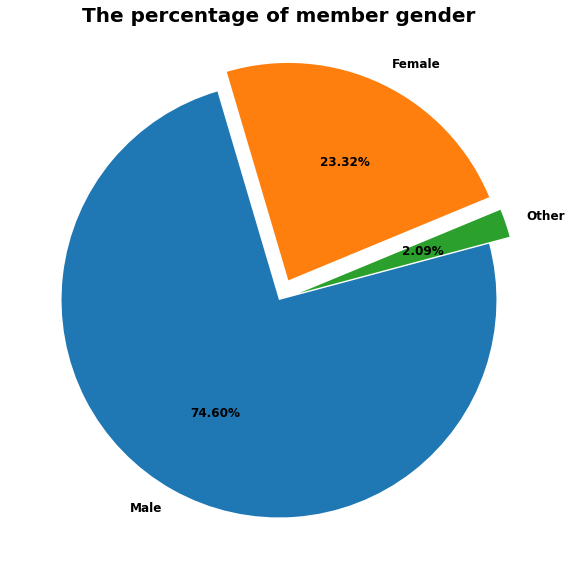

In [12]:
#Count of member gender
member_gender = master_df['member_gender'].value_counts()

# Pie chart to illustrate the proportion of among user type
plt.figure(figsize = [10,10])

plt.pie(member_gender, 
        labels = member_gender.index, 
        startangle = 15, 
        counterclock = False,
        autopct = '%1.2f%%',
        explode = [0, 0.1,0.1],
        textprops={'fontsize': 12, 'weight':'bold', 'color':'black'}
       )

plt.title('The percentage of member gender', size = 20, weight = 'bold')

plt.show();

### Proportion of user type

There is a great difference in number between Customer and Subscriber attending GoBike system where nearly 90% percent of attendants are subscriber, and Customer only accounts for 10.8%.

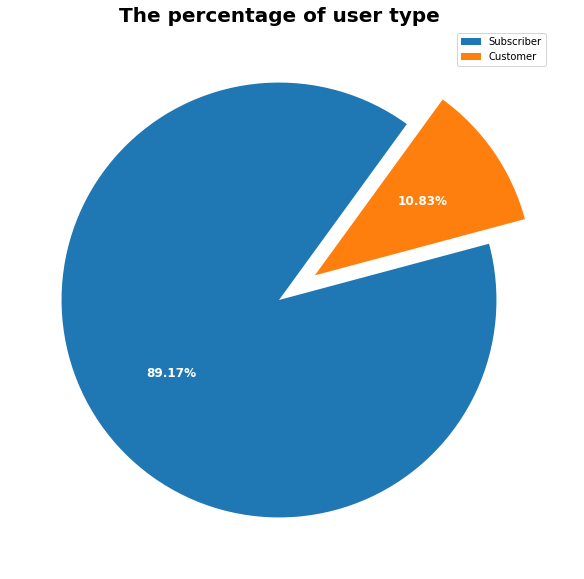

In [13]:
#Count of user type
user_type = master_df['user_type'].value_counts()

# Pie chart to illustrate the proportion of among user type
plt.figure(figsize = [15,10])

plt.pie(user_type, 
        labels = user_type.index, 
        startangle = 15, 
        counterclock = False,
        autopct = '%1.2f%%',
        explode = [0, 0.2],
        textprops={'fontsize': 12, 'weight':'bold', 'color':'w'}
       )

plt.title('The percentage of user type', size = 20, weight = 'bold')
plt.legend()

plt.show();

### Distribution of member's age by user type

- Both Customer user and Subscriber user have the same user segment where the people within the age from 25 to around 40 have the highest demand in bike.

- Most users under both types are at the age between 32 to 35 years old.

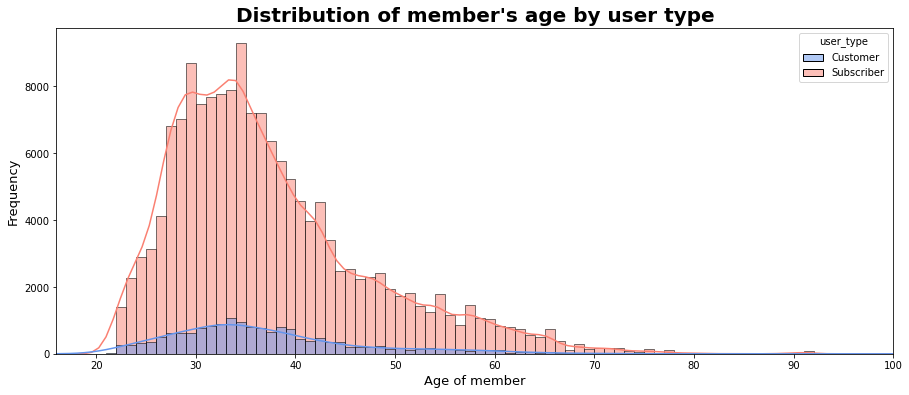

In [14]:
# illustrate the distribution of the age of member
plt.figure(figsize = [15,6])
bins = np.arange(0, master_df['member_age'].max() + 1, 1)
sns.histplot(data = master_df, 
             x = 'member_age', 
             bins = bins, 
             kde = True,
             color = base_color,
             hue = 'user_type',
             palette = ['cornflowerblue','salmon'])

plt.xlabel('Age of member',size = 13)
plt.ylabel('Frequency', size = 13)
plt.title("Distribution of member's age by user type", size = 20, weight = 'bold')

plt.xlim(16,100)

plt.show();

### Number of trip by time of day for each user type

Because the Customer user only accounts for 11%, correspondingly, the number of trips conducted of Customer user are also significantly lower than the Subscriber user. However, both users have a very same pattern in the number of trips by time of day, where they reach the peak at 8AM and 5PM, remain stable from 10AM to 3PM and go down from 7PM to the lowest point at 3AM.

(0.0, 20000.0)

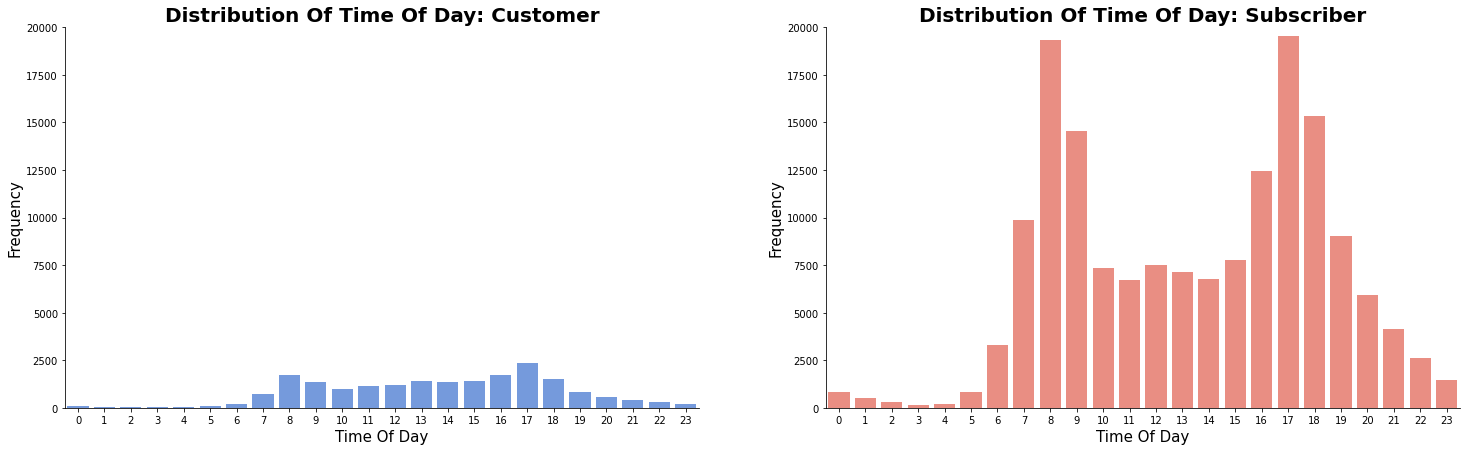

In [15]:
plt.figure(figsize = [25,7])

#Customer
plt.subplot(1,2,1)
makeCountplot(data = master_df.query('user_type == "Customer"'), xVar = 'time_of_day', color = 'cornflowerblue', figsize =None, labelsize = 15, title = ": Customer")

plt.ylim(0,20000)

#Subscriber
plt.subplot(1,2,2)
makeCountplot(data = master_df.query('user_type == "Subscriber"'), xVar = 'time_of_day', color = 'salmon', figsize =None, labelsize = 15,title = ': Subscriber') 

plt.ylim(0,20000)

### Number of trip by day of week under for each user type

The number of trips by day of week for both user type have the same pattern with the general number of trips by day of week above, high demand on weekdays and less demand on weekend.

However, for the Customer user, the records show that there is not a very significant different in the number of trips between weekend and weekdays.

<Figure size 1440x504 with 0 Axes>

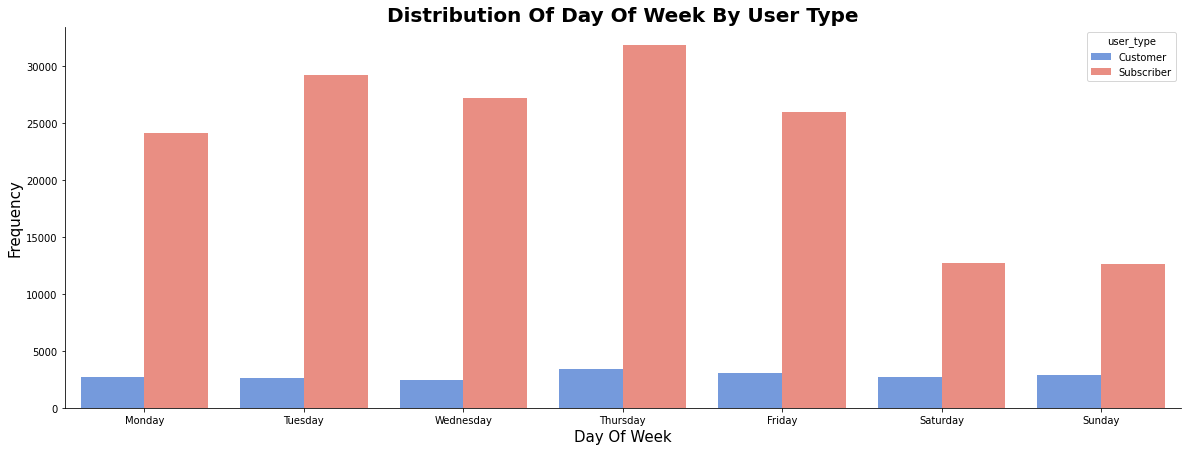

In [16]:
plt.figure(figsize = [20,7])

weekday =["Monday","Tuesday",'Wednesday','Thursday','Friday','Saturday','Sunday']

#create a value count series for day of week

makeCountplot(data = master_df, xVar = 'day_of_week', palette = ['cornflowerblue','salmon'], order = weekday, hueVar = 'user_type')


plt.show();

### Number of trip by day of month for each user type

The fluctuation in the number of trips of Subscriber users is illustrated as strong and sharp. However, for the Customer user type, the fluctuation is still there but not as sharp as the demand of Subscriber. 

Beside, instead of following the same pattern of the overall plot like the Subscriber user does, it could be seen that the number of trips for such user type does not follow the period of 5 day up and drop down at sixth, moreover, the demand have nailed at high points for a long period.

But there is a similar between two user types where the demand dropped notably on 13th of the month.

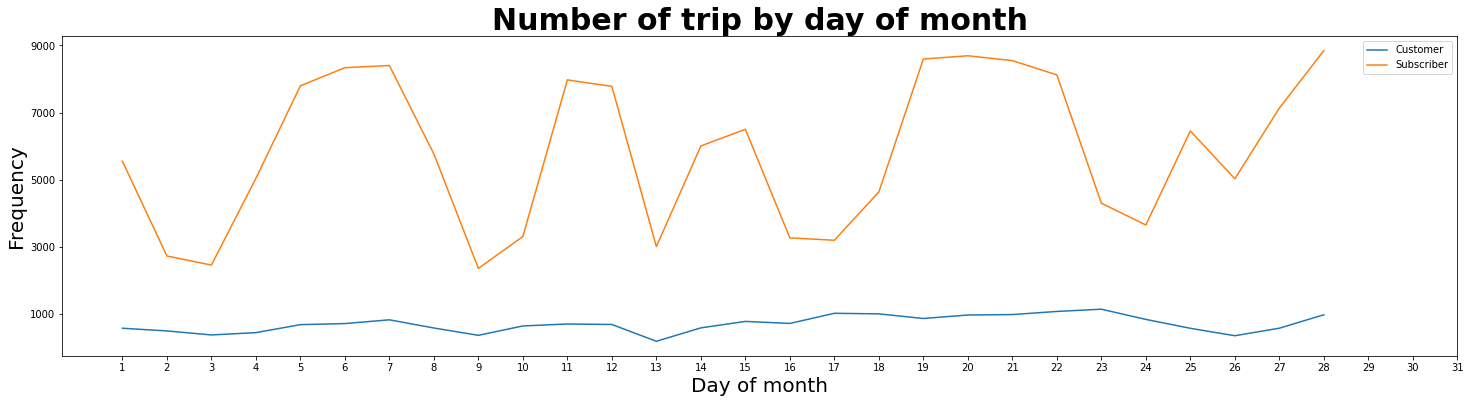

In [17]:
plt.figure(figsize = [25,20])

day_of_month = master_df[['day_of_month','user_type']].value_counts().reset_index( name = 'count')
day_of_month = day_of_month.pivot(index = 'day_of_month', columns = 'user_type', values = 'count')
                                  
#General plot        
plt.subplot(3,1,1)

makeLineplot(data = day_of_month, figsize = None, color = ['cornflowerblue','salmon'] , xticks = [1,32,1], yticks = [1000,10000,2000])
plt.legend()





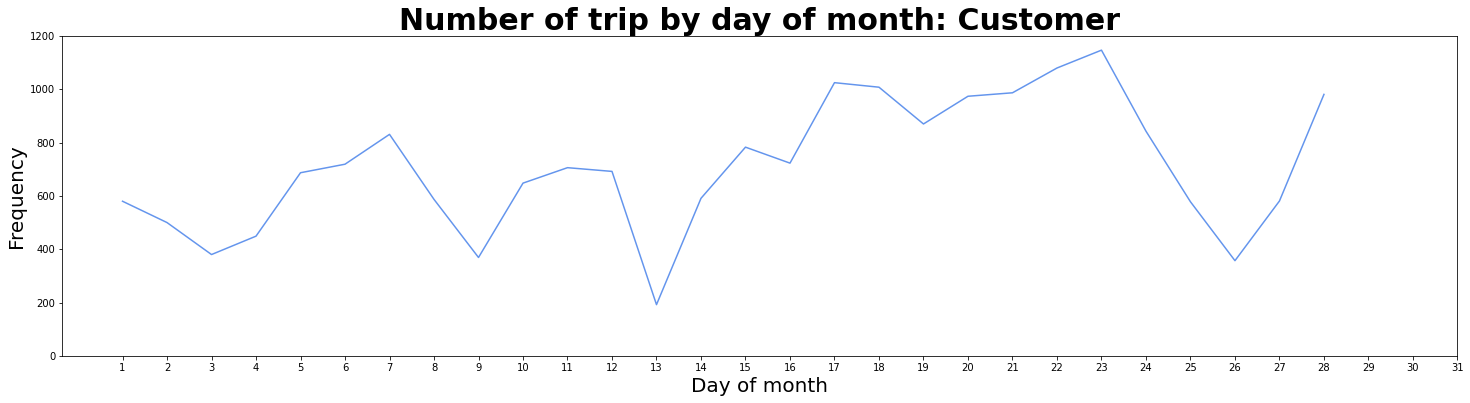

In [18]:
plt.figure(figsize = [25,20])

#Customer
plt.subplot(3,1,2)

makeLineplot(data = day_of_month, figsize = None, color ='cornflowerblue', xticks = [1,32,1], yticks = None, ylim = [0,1200], user = 'Customer')

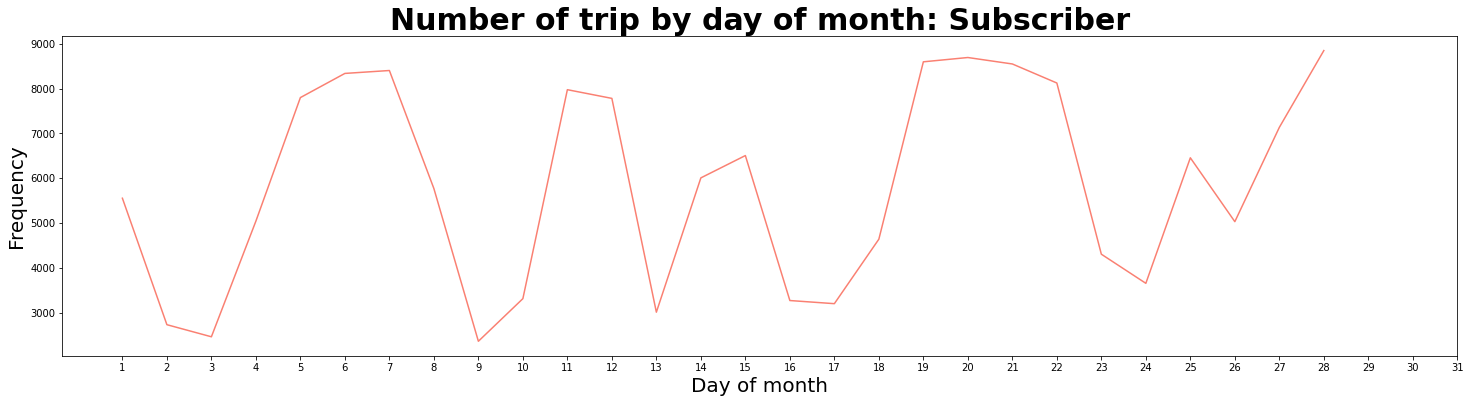

In [19]:
plt.figure(figsize = [25,20])

#Subscriber
plt.subplot(3,1,3)

makeLineplot(data = day_of_month, figsize = None, color ='salmon', xticks = [1,32,1], yticks = None, user = 'Subscriber')

### Duration of trip by age of member

- Most of the trips are under 50 minutes and group with age around 30 have made the most travel by bike with more than 83K trips in February 2019.

- At each range of member's age:
    + **From 20 to under 30** the older the people are, the longer they ride bike. At around 20 years old, the majority of people only take the longest ride at 10 to 13 minutes while this duration expands up to 20 minutes for the those people who are around 30. At this stage, there is a clear trend could be observed while more people ride bike and they ride bike longer. 
    + **From 30 to under 40** for the trips under 50 minutes long, there are 83K trips conducted and we can see the trend of riding bike longer reach the peak at 22-24 minutes max and the age of member is around from 32 to 35, which means more people within this age ride longer than any age segment.
    + **From 40 to 90** the trend of most people riding longer at this stage slightly drop over member age and only a few trips conducted at the age of around 80 and 90.

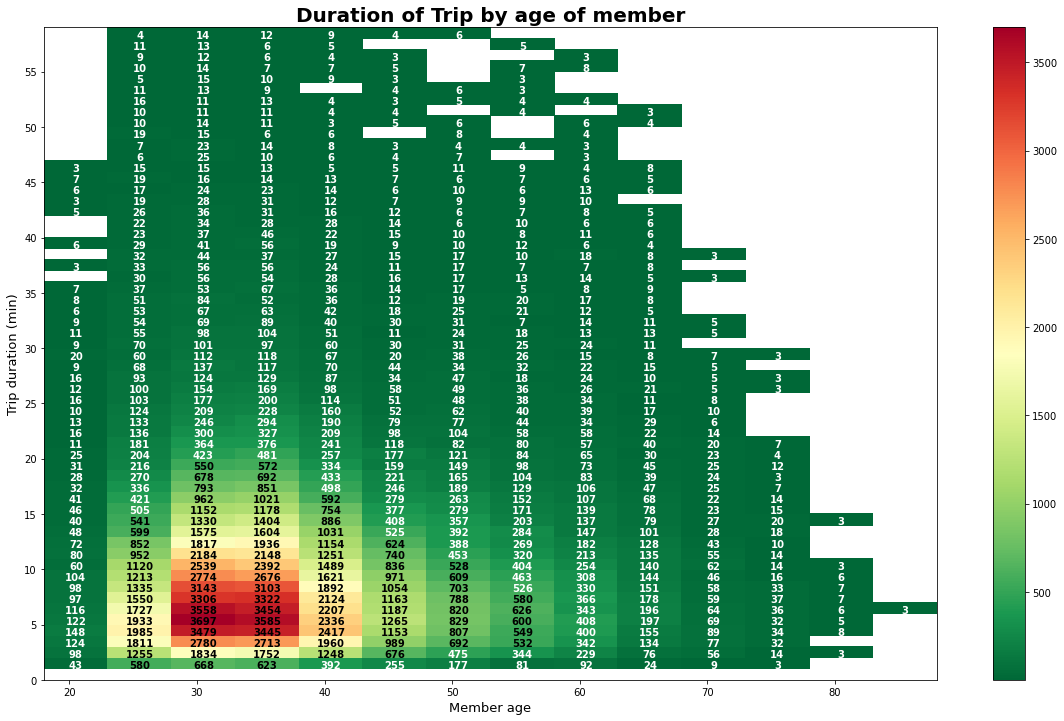

In [20]:
#duration vs age
eligible_age = master_df.query('18 < member_age < 90')

x_interval = 5 #5 years
y_interval = 1 #1 minutes
plt.figure(figsize = [20,12])
bins_x = np.arange(18, 90, x_interval)
bins_y = np.arange(0, 60, y_interval)

# Use cmin to set a minimum bound of counts 
# Use cmap to reverse the color map. 
h2d = plt.hist2d(data = eligible_age, x = 'member_age', y = 'duration_min', cmin=3, cmap='RdYlGn_r',
                 bins = [bins_x,bins_y])

y_ticks = [i for i in range(0,60,5)]
ytck_label = ['{}'.format(i) for i in y_ticks]

plt.colorbar()
plt.xlabel('Member age', size = 13)
plt.ylabel('Trip duration (min)', size = 13)
plt.title('Duration of Trip by age of member', size = 20, weight = 'bold')
plt.yticks(y_ticks, ytck_label);

# Select the bi-dimensional histogram, a 2D array of samples x and y. 
# Values in x are histogrammed along the first dimension and 
# values in y are histogrammed along the second dimension.
counts = h2d[0]

# # Add text annotation on each cell
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= np.nanquantile(counts,.85): # increase visibility on darker cells
            plt.text(bins_x[i]+ x_interval/2, bins_y[j]+.3, int(c),
                     ha = 'center', va = 'center', color = 'black', weight = 'bold')
        elif c > 0:
            plt.text(bins_x[i]+x_interval/2, bins_y[j]+.3, int(c),
                     ha = 'center', va = 'center', color = 'white', weight = 'bold')



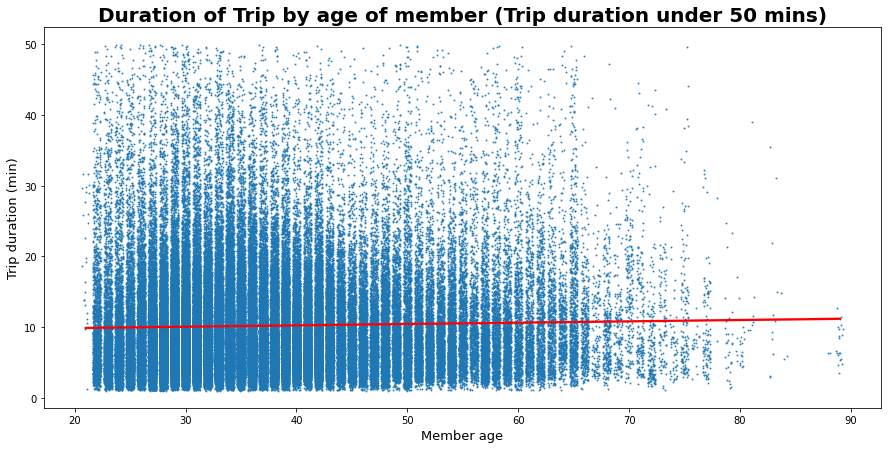

In [21]:
#Because the visualization only focus on the duration min lower than 400 min
eligible_age = eligible_age.query('50 >= duration_min')

plt.figure(figsize = [15,7]) 
sns.regplot(data = eligible_age, 
            x = 'member_age', 
            y = 'duration_min',
            x_jitter = 0.35,
            scatter_kws = {'s': 1},
            line_kws = {'color' : "r"}
           )

plt.xlabel('Member age', size = 13)
plt.ylabel('Trip duration (min)', size = 13)
plt.title('Duration of Trip by age of member (Trip duration under 50 mins)', size = 20, weight = 'bold')

plt.show();


### Count of trip under day of week and time of day (hour) for each user type

In overall, the number of trips taken of subscriber is far higher than customer as the cooler color of customer.

- For Customer users, they use bike more on 8AM and 5PM on weekdays and 10AM to 5PM on weekend. The different in the peak time between weekend and weekdays is not very significant.
- For Subscriber users, it is similar to the Customer user type, however, on weekend, the peak time of using bike is from 10AM to 7PM. 

In [22]:
#create a function to create heatmap plot for user type
def makeHeatplot(user):
    trip_user = master_df[master_df['user_type'] == user]
    user_df = trip_user[['day_of_week','time_of_day']].value_counts().reset_index(name = 'count')

    user_pivot = user_df.pivot(index = 'day_of_week', columns = 'time_of_day', values = 'count').reindex(weekday_invert)

    sns.heatmap(user_pivot,
                cmap = 'Oranges',
                robust = False,
                vmin = 0, vmax = 4300,
                annot = True, fmt=".0f")

    plt.xlabel('Time of day (hour)', size = 13)
    plt.ylabel('Day of week', size = 13)
    plt.title(f'''Count of trip under day of week and time of day (hour): {user}''', size = 20, weight = 'bold')
    plt.yticks(rotation = 0)

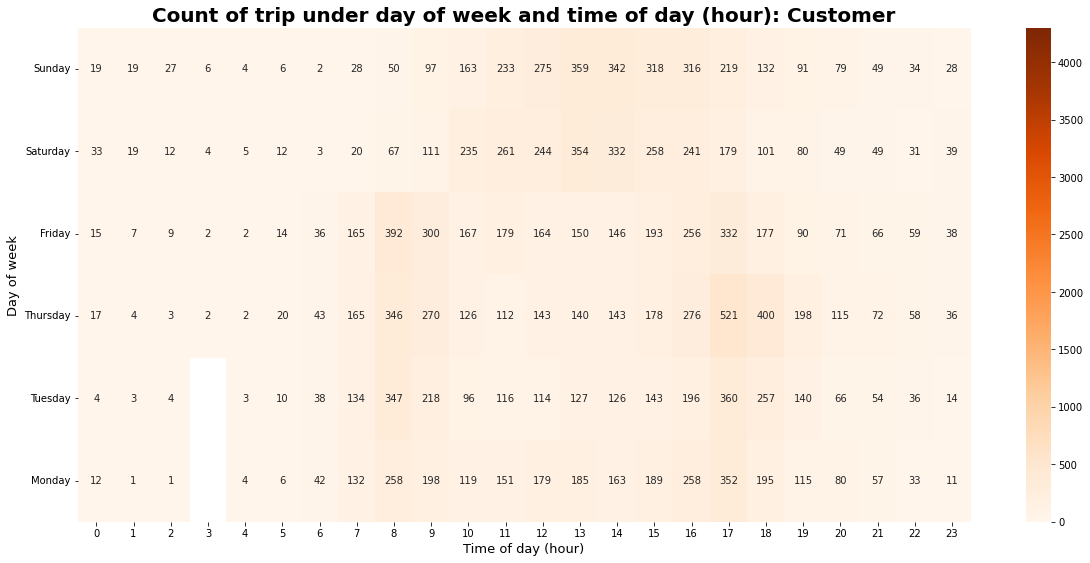

In [23]:
plt.figure(figsize = [20,20])

weekday_invert = ['Sunday','Saturday','Friday','Thursday','Tuesday','Monday']

#Customer
plt.subplot(2,1,1)
makeHeatplot('Customer')

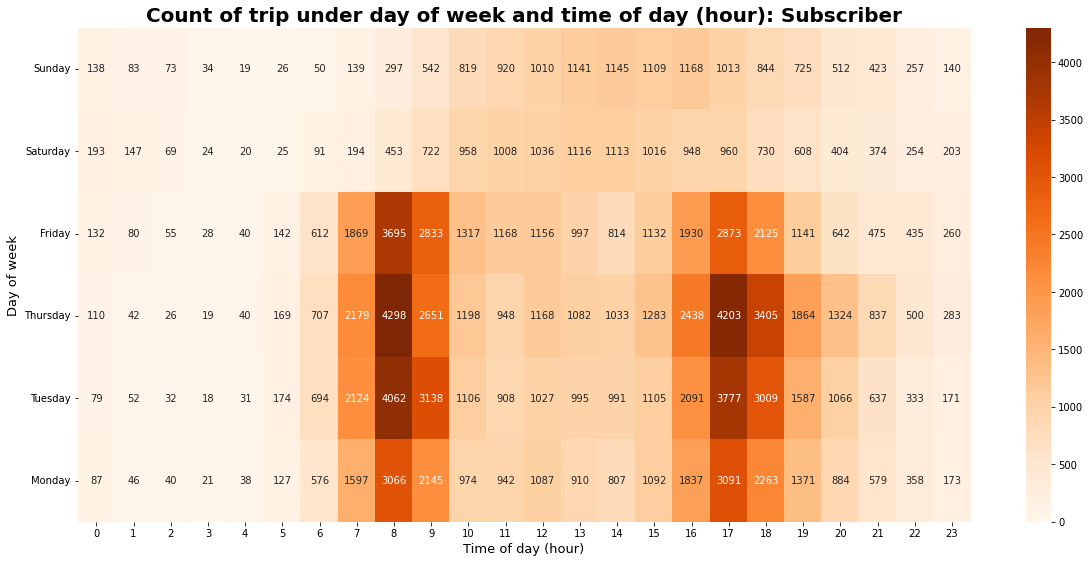

In [24]:
plt.figure(figsize = [20,20])

#Subscriber
plt.subplot(2,1,2)
makeHeatplot('Subscriber')

### Average trip duration by member age for each user type

- The maximum value of average trip duration for Customer user and Subscriber user shows that he Customer users take longer trip than Subscriber user
- For the Customer user, there is a burst in the demand for the users within the age of 21 to 34, however, the average trip duration goes in a contrast trend from nearly 24 min down to 15 min. After the point of 34, the number of trip decrease sharply to 0 but the average duration trip spikes up to nearly 30 minutes.
- For the Subscriber user, as the same as the Customer user, the number of trips burst along with the age of member from 21 to 34, but unlike the Customer, the average duration remains stable at 9 mins to the point of 59 years old. From the point of 34 onward, the number of trip decrease as well, but the average duration of a trip goes up.

In [25]:
#In order to generate a plot containing information of both average duration of trip and number of trip taken
#It is neccessary to create a function to prepare a dataframe storing two information by member age

def df_for_plotting(eligible_age, user_type):
    #create a dummy dataset containing full age range
    age_dummy = pd.DataFrame([i for i in range (eligible_age.member_age.min(),eligible_age.member_age.max())], 
                             columns = ['member_age'])

    eligible_age = eligible_age.query('user_type == "{}"'.format(user_type))
    
    #Prepare the data for average duration
    average_duration = eligible_age.groupby('member_age').duration_min.mean().reset_index(name = 'avg_duration')

    #Prepare the data for number of trip
    count_age = eligible_age['member_age'].value_counts().reset_index(name = 'count')
    trip_count = count_age.sort_values('index')

    #create customer_age with full age range
    df = age_dummy.merge(average_duration, on = 'member_age', how = 'left')
    df = df.merge(trip_count, 
                  left_on = 'member_age',
                  right_on = 'index',
                  how ='left').drop('index', axis = 1)
    
    df.fillna(0, inplace = True)
    df[['avg_duration','count']] = df[['avg_duration','count']].astype('int')
    
    return df

In [26]:
#create a function to make a combo plot for user type
def makeComboplot(user, ax, barColor, lineColor):
    customer_age = df_for_plotting(eligible_age, user)

    sns.barplot(ax = ax, data = customer_age, x = 'member_age', y = 'avg_duration', color = barColor)
    ax1 = ax.twinx()
    sns.lineplot(ax = ax1, data = customer_age, x = ax1.get_xticks() ,y = 'count', color = lineColor)

    ax.set_xlabel('Member age', size = 25)
    ax.set_ylabel('Average trip duration (min)', size = 25)
    ax1.set_ylabel('Frequency', size = 25)
    ax.set_title(f'''Average trip duration by member age: {user}''', size = 40, weight = 'bold')
    ax.tick_params(axis = 'y',labelsize = 25)
    ax.tick_params(axis = 'x', labelsize =16)
    ax1.tick_params(axis = 'y', labelsize = 25);

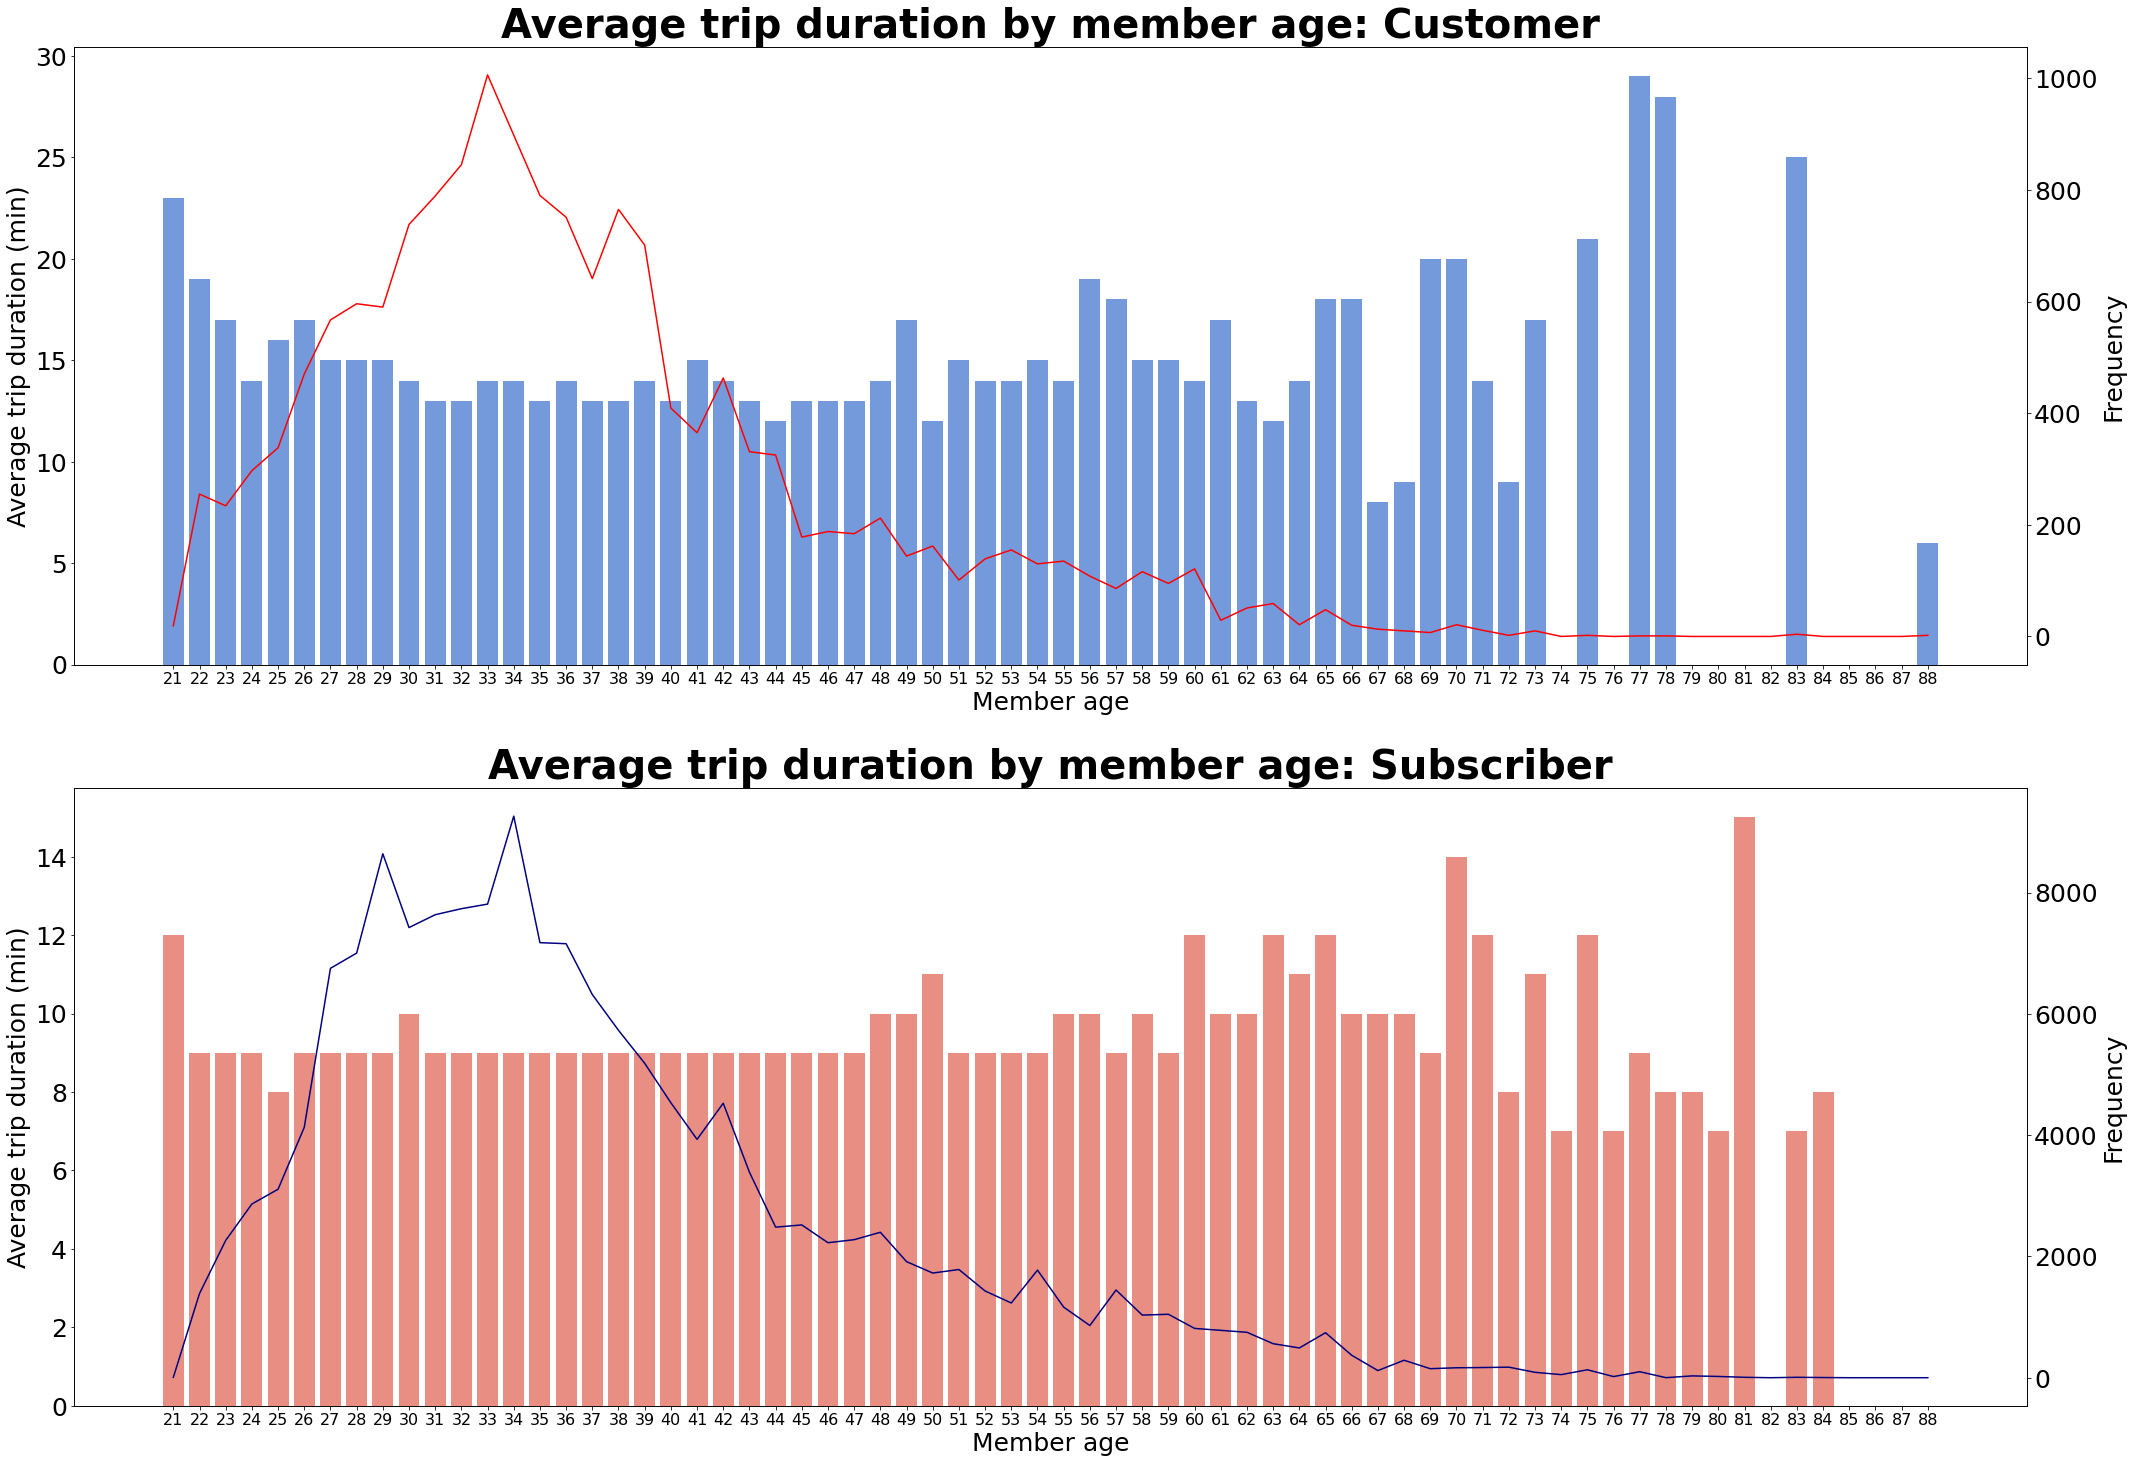

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = [35,25])

#Customer
makeComboplot('Customer', ax1, 'cornflowerblue', 'r')


#Subscriber
makeComboplot('Subscriber', ax2, 'salmon', 'Navy')

plt.show()